In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping

# **EDA**

In [148]:
dataset = pd.read_csv("/kaggle/input/q4-stock-data/question4-stock-data.csv")

def dataset_info():
    print(f"\nDataset contains {len(dataset)} rows and {len(dataset.columns)} columns.\n")
    print("\nMissing Values per Column:")
    print(dataset.isnull().sum())
    print("\nDuplicate Rows:", dataset.duplicated().sum())
    print("")

dataset.dropna(subset=["Date", "Close"], inplace=True)
dataset.ffill(inplace=True)
dataset_info()

dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.sort_values(by='Date', inplace=True)
dataset.reset_index(drop=True, inplace=True)

dataset.head()


Dataset contains 11065 rows and 8 columns.


Missing Values per Column:
Unnamed: 0    0
Date          0
Adj Close     0
Close         0
High          0
Low           0
Open          0
Volume        0
dtype: int64

Duplicate Rows: 0



,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume
0,0,1980-03-17,2.296798,3.291227,3.344743,3.291227,0.000000,41109.0
1,1,1980-03-18,2.306134,3.304606,3.358122,3.304606,0.000000,9343.0
2,2,1980-03-19,2.306134,3.304606,3.304606,3.304606,3.304606,0.0
3,3,1980-03-20,2.306134,3.304606,3.358122,3.304606,0.000000,10277.0
4,4,1980-03-21,2.362154,3.384880,3.438396,3.384880,0.000000,8409.0


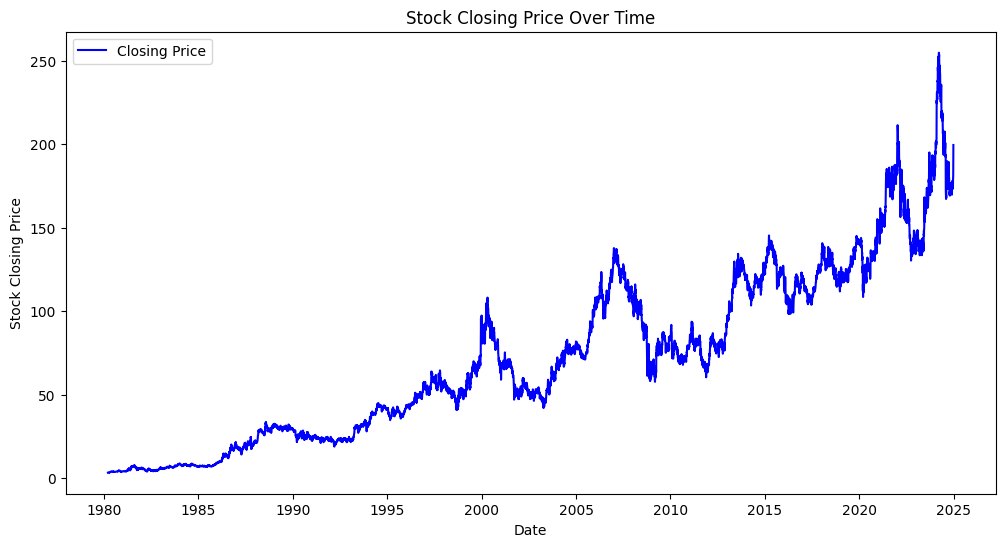

In [142]:
plt.figure(figsize=(12, 6))
plt.plot(dataset['Date'], dataset['Close'], label="Closing Price", color='blue')
plt.xlabel("Date")
plt.ylabel("Stock Closing Price")
plt.title("Stock Closing Price Over Time")
plt.legend()
plt.show()

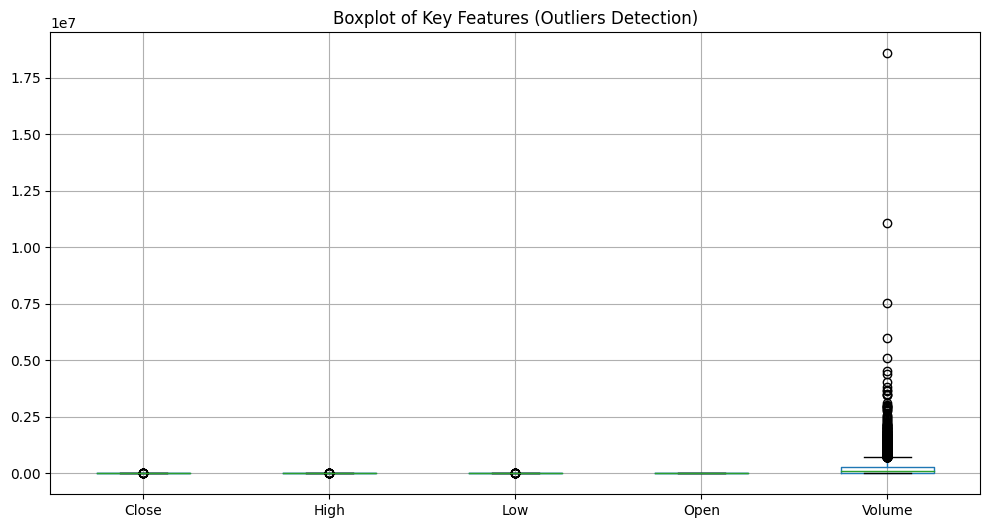

In [143]:
plt.figure(figsize=(12, 6))
dataset[['Close', 'High', 'Low', 'Open', 'Volume']].boxplot()
plt.title("Boxplot of Key Features (Outliers Detection)")
plt.show()

In [149]:
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    
    return df

columns_to_check = ["Volume"]

dataset_cleaned = remove_outliers_iqr(dataset, columns_to_check)

print(f"Cleaned dataset: {dataset_cleaned.shape}")

dataset = dataset_cleaned

Cleaned dataset: (10403, 8)


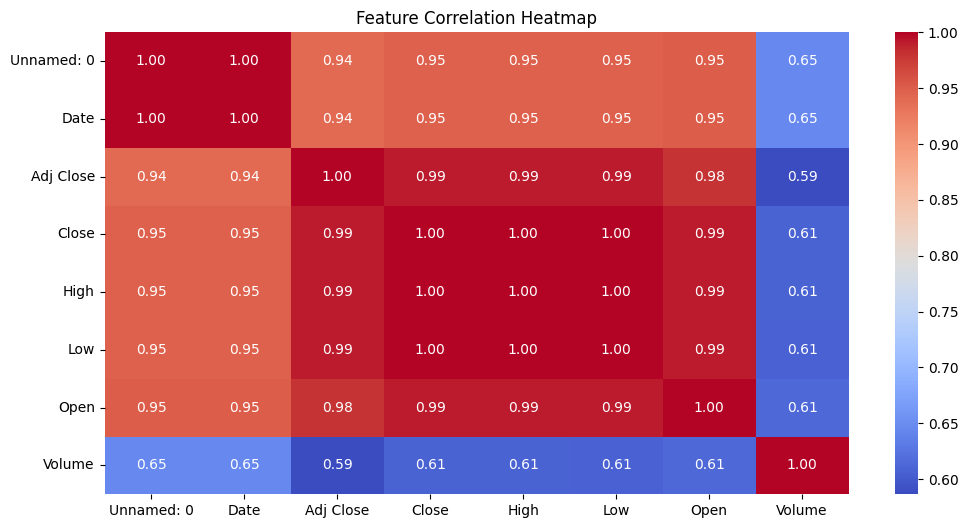

In [150]:
plt.figure(figsize=(12, 6))
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [151]:
dataset = dataset.drop(columns=["Unnamed: 0", 'High', 'Low', 'Open', 'Adj Close'])

print("Updated dataset shape:", dataset.shape)
dataset.head()

Updated dataset shape: (10403, 3)


,Date,Close,Volume
0,1980-03-17,3.291227,41109.0
1,1980-03-18,3.304606,9343.0
2,1980-03-19,3.304606,0.0
3,1980-03-20,3.304606,10277.0
4,1980-03-21,3.384880,8409.0


In [152]:
dataset['MA_5'] = dataset['Close'].rolling(window=5).mean()
dataset['Log_Return'] = np.log(dataset['Close'] / dataset['Close'].shift(1))
dataset['Volatility_15'] = dataset['Close'].rolling(window=15).std()

dataset['Momentum_5'] = dataset['Close'] - dataset['Close'].shift(5)

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

dataset['RSI_14'] = compute_rsi(dataset['Close'], period=14)

for lag in range(1, 16):  
    dataset[f'Close_Lag_{lag}'] = dataset['Close'].shift(lag)
    dataset[f'Volume_Lag_{lag}'] = dataset['Volume'].shift(lag)

dataset.dropna(inplace=True)  

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


          Feature  MI Score
6     Close_Lag_1  3.912429
1            MA_5  3.763136
8     Close_Lag_2  3.540717
10    Close_Lag_3  3.340500
12    Close_Lag_4  3.230346
14    Close_Lag_5  3.119942
16    Close_Lag_6  3.062100
18    Close_Lag_7  2.982053
20    Close_Lag_8  2.940860
22    Close_Lag_9  2.898931
24   Close_Lag_10  2.859601
26   Close_Lag_11  2.819394
28   Close_Lag_12  2.789164
30   Close_Lag_13  2.765065
32   Close_Lag_14  2.748527
34   Close_Lag_15  2.716904
3   Volatility_15  0.937208
2      Log_Return  0.680220
7    Volume_Lag_1  0.667933
11   Volume_Lag_3  0.665987
9    Volume_Lag_2  0.662329
15   Volume_Lag_5  0.659123
0          Volume  0.657761
35  Volume_Lag_15  0.656987
21   Volume_Lag_8  0.656046
33  Volume_Lag_14  0.655464
23   Volume_Lag_9  0.653379
13   Volume_Lag_4  0.653265
17   Volume_Lag_6  0.647497
25  Volume_Lag_10  0.646051
31  Volume_Lag_13  0.643608
29  Volume_Lag_12  0.642588
19   Volume_Lag_7  0.641577
27  Volume_Lag_11  0.635424
4      Momentum_5  0

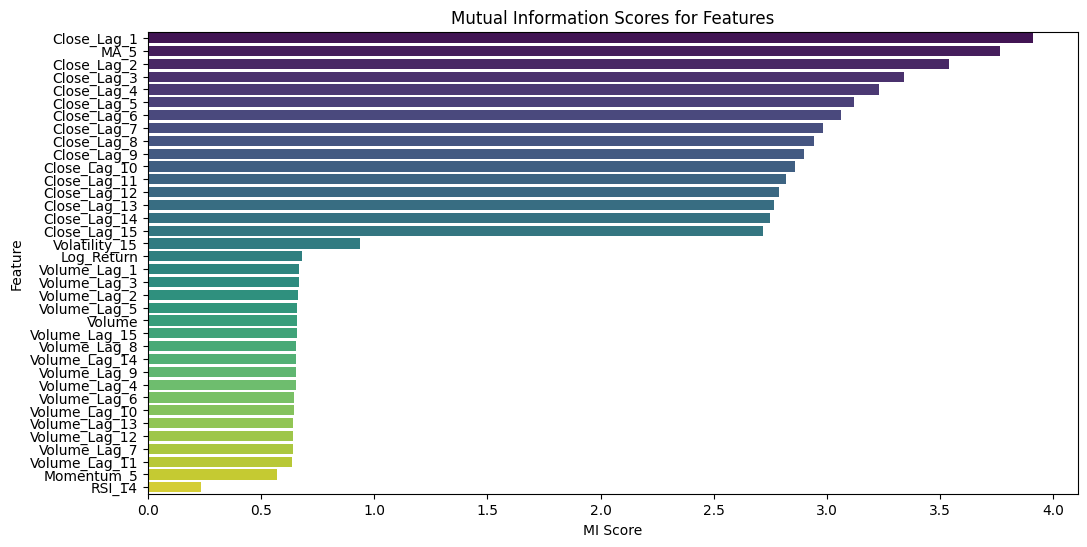

In [153]:
features = dataset.drop(columns=['Close', 'Date'])  
target = dataset['Close']

mi_scores = mutual_info_regression(features, target)

mi_df = pd.DataFrame({'Feature': features.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

print(mi_df)

plt.figure(figsize=(12, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_df, palette='viridis')
plt.title("Mutual Information Scores for Features")
plt.show()

In [154]:
selected_features = [
    "Close_Lag_1", "MA_5", "Close_Lag_2", "Close_Lag_3", "Close_Lag_4", "Close_Lag_5",
"Close_Lag_6", "Close_Lag_7", "Close_Lag_8", "Close_Lag_9", "Close_Lag_10", "Volatility_15", "Log_Return"]
dataset = dataset[selected_features]

scaler = StandardScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=dataset.columns)

dataset["Target"] = dataset["Close_Lag_1"].shift(-5)

dataset.dropna(inplace=True)

X = dataset.drop(columns=["Target"])
y = dataset["Target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# **Model Fitting**

In [155]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(X_train, y_train)
svr_pred = svr.predict(X_test)

gbm = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, max_depth=5, random_state=42)
gbm.fit(X_train, y_train)
gbm_pred = gbm.predict(X_test)

In [156]:
def evaluate_model(y_test, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    actual_direction = np.sign(np.diff(y_test.values))
    predicted_direction = np.sign(np.diff(y_pred))
    directional_accuracy = np.mean(actual_direction == predicted_direction) * 100
    
    print(f"{model_name} -> Directional Accuracy: {directional_accuracy:.2f}%, RMSE: {rmse}")

evaluate_model(y_test, lr_pred, "Linear Regression")
evaluate_model(y_test, rf_pred, "Random Forest")
evaluate_model(y_test, ridge_pred, "Ridge Regression")
evaluate_model(y_test, xgb_pred, "XGBoost")
evaluate_model(y_test, svr_pred, "SVR")
evaluate_model(y_test, gbm_pred, "Gradient Boosting")

Linear Regression -> Directional Accuracy: 50.05%, RMSE: 0.08683688273907983
Random Forest -> Directional Accuracy: 49.52%, RMSE: 0.5509087532761323
Ridge Regression -> Directional Accuracy: 48.75%, RMSE: 0.09226846026933141
XGBoost -> Directional Accuracy: 48.03%, RMSE: 0.554101837122874
SVR -> Directional Accuracy: 50.14%, RMSE: 0.7367358852472983
Gradient Boosting -> Directional Accuracy: 49.86%, RMSE: 0.5580560744652091


In [157]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=6, 
    restore_best_weights=True,
    verbose=1
)

In [158]:
lookback = 30
target_days = 5  

close_scaler = MinMaxScaler()
dataset["Close_Lag_1"] = close_scaler.fit_transform(dataset[["Close_Lag_1"]])

scaler = MinMaxScaler()
dataset_scaled = scaler.fit_transform(dataset)

X, y = [], []
for i in range(len(dataset_scaled) - lookback - target_days):
    X.append(dataset_scaled[i : i + lookback])
    y.append(dataset_scaled[i + lookback + target_days - 1, 0]) 

X, y = np.array(X), np.array(y)

split = int(0.8 * len(X))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(lookback, X.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, 
          y_train, 
          epochs=50,
          batch_size=32, 
          validation_data=(X_test, y_test), 
          callbacks = [early_stopping],
          verbose=1)

lstm_preds_test = model.predict(X_test).reshape(-1, 1)

lstm_preds_rescaled = close_scaler.inverse_transform(lstm_preds_test).flatten()
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = mean_squared_error(y_test_rescaled, lstm_preds_rescaled, squared=False)

def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100

direction_acc = directional_accuracy(y_test_rescaled, lstm_preds_rescaled)

print(f"LSTM -> Directional Accuracy: {direction_acc:.2f}%, RMSE: {rmse}")

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


259/259 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0076 - val_loss: 0.0017
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 7.2957e-04 - val_loss: 0.0015
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 5.7502e-04 - val_loss: 0.0022
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 5.0497e-04 - val_loss: 5.9453e-04
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4.5169e-04 - val_loss: 6.8661e-04
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 4.5216e-04 - val_loss: 5.9186e-04
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.8226e-04 - val_loss: 5.5926e-04
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.3949e-04 - val_loss: 6.9537e-04
Epoch 9/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.3205e-04 - val_loss: 4.6672e-04
Epoch 10/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 3.0553e-04 - val_loss: 0.0010
Epoch 11/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 2.7970e-04 - val_l

In [165]:
lstm_preds_test = model.predict(X_test).reshape(-1, 1)
y_train = y_train[:lstm_preds_train.shape[0]]

svr = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr.fit(lstm_preds_train, y_train)
svr_preds = svr.predict(lstm_preds_test)

gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(lstm_preds_train, y_train)
gb_preds = gb.predict(lstm_preds_test)

w_lstm, w_svr, w_gb = 0.7, 0.15, 0.15  
final_preds = (w_lstm * lstm_preds_test.flatten()) + \
              (w_svr * svr_preds) + \
              (w_gb * gb_preds)

final_preds_rescaled = close_scaler.inverse_transform(final_preds.reshape(-1, 1)).flatten()
y_test_rescaled = close_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = mean_squared_error(y_test_rescaled, final_preds_rescaled, squared=False)

def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(np.diff(y_true)) == np.sign(np.diff(y_pred))) * 100

direction_acc = directional_accuracy(y_test_rescaled, final_preds_rescaled)

print(f"LSTM + Soft Voting (LSTM, SVR, Gradient Boosting) -> Directional Accuracy: {direction_acc:.2f}%, RMSE: {rmse}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
LSTM + Soft Voting (LSTM, SVR, Gradient Boosting) -> Directional Accuracy: 68.78%, RMSE: 0.16536864515037433
